In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import pymc3 as pm
import networkx as nx

## Helper Functions

In [166]:
from collections import OrderedDict
class BayesianNetwork(nx.DiGraph):
    '''
    keeps track of the order in which nodes are added to the graph, 
    and the order in which neighbors are declared
    '''
    node_dict_factory = OrderedDict
    adjlist_dict_factory = OrderedDict
    def d(self, n):
        '''get node distribution by name'''
        try:
            return self.node[n]['dist']
        except:
            print 'Node either doesn\'t exist or has not been\
            assigned a distribution'
            raise NotImplementedError
            
# print(nx.ancestors(D, 'Y_obs'))

# general args for all(most?) PyMC3 RV objects
Dist_args = {'observed', 'shape', 'testval'}

# Dist-specific arguments for PyMC3 RV objects
def get_args(G, n):
    
    Norm_args = {'mu', 'sd'}
    HalfNorm_args = {'sd'}
    Expon_args = {'lam'}
    Unif_args ={'lower','upper'}
    Poisson_args = {'mu'}
    Det_args = {'var'}
    GRW_args = {'tau'}
    StuT_args = {'nu','lam'}
    try:
        dist_type = G.node[n]['dist_type']
    except:
        print 'Node either doesn\'t exist or has not been\
        assigned a distribution'
        raise NotImplementedError
# pm.StudentT()
    if dist_type=='Normal':
        return Norm_args
    elif dist_type=='HalfNormal':
        return HalfNorm_args
    elif dist_type=='Exponential':
        return Expon_args
    elif dist_type in ['DiscreteUniform', 'Uniform']:
        return Unif_args
    elif dist_type=='Poisson':
        return Poisson_args
    elif dist_type in ['Deterministic', 'Potential']:
        return Det_args
    elif dist_type=='GaussianRW':
        return GRW_args
    elif dist_type=='StudentT':
        return StuT_args
        
    else: 
        print "Dists of type {} are not implemented".format(G.node[n]['dist'])
        raise NotImplementedError

def draw_net(D):
    try:
        pos = graphviz_layout(D, prog='dot')
        plt.figure()
        nx.draw_networkx_nodes(D, pos,
                               nodelist=[n for n in D.nodes() if 'observed' in D.node[n]],
                               with_labels=True, node_size=1000, node_color='yellow')
        nx.draw_networkx_nodes(D, pos,
                               nodelist=[n for n in D.nodes() if not 'observed' in D.node[n]],
                               with_labels=True, node_size=1000, node_color='gray')
        nx.draw_networkx_labels(D, pos)
        nx.draw_networkx_edges(D, pos, arrows=True)
        nx.draw_networkx_edge_labels(D, pos, rotate=False,
                                     edge_labels={k:D.edge[k[0]][k[1]]['var'] for k in D.edges()})
    except:
        print 'You probably need to install Graphviz or have a working "dot" command in your PATH.'
        raise
        
def instantiate_pm(D):    
    for n in D.nodes():
        print n
        if not D.predecessors(n): # check if the node is a root (implicit booleanness of empty set)
            varset =  D.node[n].viewkeys() & (get_args(D, n)|Dist_args)
            args = {k: D.node[n][k] for k in varset}
            print 'root node; keys: ',args.keys()
            D.node[n]['dist'] = D.node[n]['dist'](n, **args)
        else: 
            args = {k: D.node[n][k] for k in D.node[n].viewkeys() & Dist_args}
#             print 'pre-args: ',args
            for var in list(get_args(D, n)):  # a set for each unique edge functional relationship
#                 parents = [i for i in D.predecessors(n)[::-1] if D.edge[i][n]['var']==var]
#                 print var, parents
                ### ORDER OF NODE DEFINITION MUST be the ORDER OF ARGUMENTS
#                 args.update({var: D.node[n][var](*parents)})
                args.update({var: D.node[n][var]()})
            print 'child node; keys: ', args.keys()
            D.node[n]['dist'] = D.node[n]['dist'](n, **args)
        


## Model 1 (lin. Regression)

In [59]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

In [85]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('alpha', dist = pm.Normal, mu=0, sd=10, dist_type='Normal')
D.add_node('beta', dist = pm.Normal, mu=0, sd=10, shape=2, dist_type='Normal')
D.add_node('sigma', dist = pm.HalfNormal, sd=1, dist_type='HalfNormal')

# inheriting nodes need to have functions as attributes to be called at runtime. 
### ORDER OF NODE DEFINITION MUST be the ORDER OF ARGUMENTS
D.add_node('Y_obs', dist = pm.Normal, 
           mu = lambda: D.d('alpha')+\
           D.d('beta')[0]*X1+\
           D.d('beta')[1]*X2,
          sd = lambda: D.d('sigma'), 
          observed=Y,
          dist_type='Normal')
D.add_edges_from([('alpha','Y_obs'),('beta','Y_obs')], var='mu')
D.add_edges_from([('sigma','Y_obs')], var='sd')
# [i for i in nx.ancestors(D, 'Y_obs') if D.edge[i]['Y_obs']['var']=='sd']

{('alpha', 'Y_obs'): <matplotlib.text.Text at 0x327fe908>,
 ('beta', 'Y_obs'): <matplotlib.text.Text at 0x327fe3c8>,
 ('sigma', 'Y_obs'): <matplotlib.text.Text at 0x327fe630>}

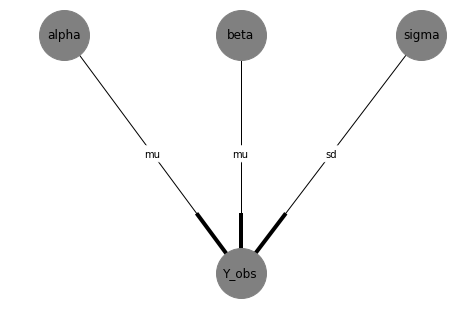

In [86]:
from networkx.drawing.nx_pydot import graphviz_layout,write_dot # pygraphviz

pos=graphviz_layout(D,prog='dot')
nx.draw(D,pos,with_labels=True,arrows=True, node_size=2500, node_color='gray')
nx.draw_networkx_edge_labels(D, pos, rotate=False, edge_labels={k:D.edge[k[0]][k[1]]['var'] for k in D.edges()})
# plt.scatter()
# write_dot(G,'pymc3.dot')
# !dot -Tpng pymc3.dot >pymc3.png

In [87]:
with pm.Model() as model:
    instantiate_pm(D)

alpha
['mu', 'sd']
beta
['mu', 'shape', 'sd']
sigma
['sd']
Y_obs
['observed', 'mu', 'sd']


In [88]:
with model:
#     step = pm.Metropolis()
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -368.91:  14%|█▏      | 28300/200000 [00:02<00:14, 11986.54it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -154.13

100%|█████████████████████████████████████| 2000/2000 [00:02<00:00, 956.02it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000338779E8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000033A22BE0>]], dtype=object)

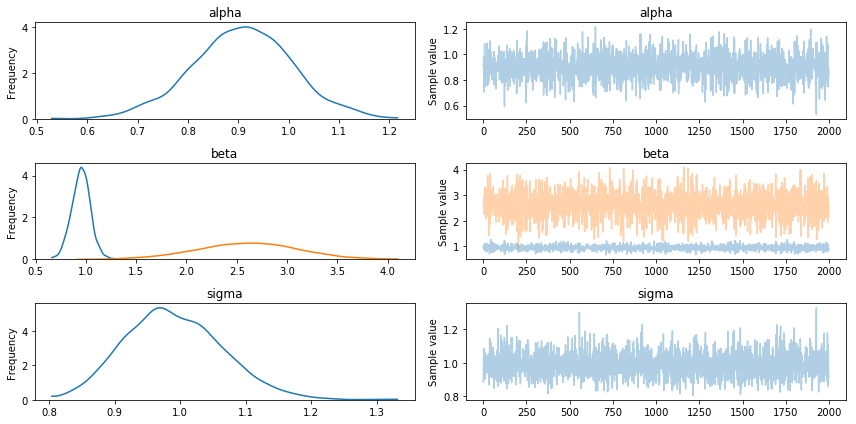

In [89]:
pm.traceplot(trace)

`![pymc3_net](pymc3.png)`

## Model 2: Coal-mining Switchpoint

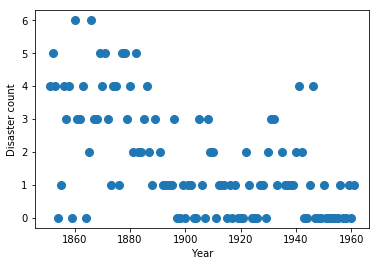

In [90]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                            3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                            2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                            1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                            0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                            3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                            0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], value=-999)
year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

In [91]:
D = BayesianNetwork()
# root nodes can be defined staticly. 
D.add_node('switchpoint', dist = pm.DiscreteUniform, 
           lower=year.min(), upper=year.max(), 
           dist_type='DiscreteUniform', testval=1900)

D.add_node('early_rate', dist = pm.Exponential, lam=1., dist_type='Exponential')
D.add_node('late_rate', dist = pm.Exponential, lam=1., dist_type='Exponential')

# make sure to assume strings as input (node names) and use
# node dist as the vars
rate = lambda: pm.math.switch(1*(D.d('switchpoint') >= year), 
                                      D.d('early_rate'), 
                                      D.d('late_rate'))

# inheriting nodes need to have functions as attributes 
# to be called at runtime. 
### ORDER OF NODE DEFINITION MUST be the ORDER OF ARGUMENTS 
### and ORDER of EDGE DEFINITION
D.add_node('disasters', dist = pm.Poisson, 
           mu = rate,
           observed=disaster_data,
          dist_type='Poisson')

           
D.add_edges_from([('late_rate','disasters'),
                  ('early_rate','disasters'),
                  ('switchpoint','disasters')], var='mu')

In [92]:
D.predecessors('disasters')[::-1]

['switchpoint', 'early_rate', 'late_rate']

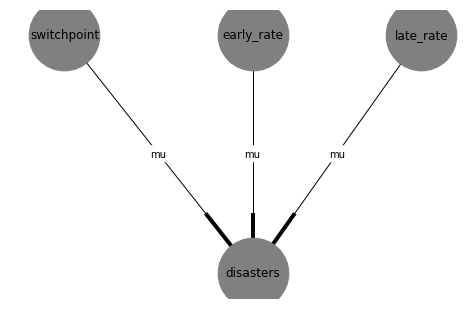

In [93]:
labels = {k:D.edge[k[0]][k[1]]['var'] for k in D.edges()}
pos=graphviz_layout(D,prog='dot')
nx.draw(D,pos,with_labels=True,arrows=True, node_size=5000, node_color='gray')
nx.draw_networkx_edge_labels(D, pos, rotate=False, 
                             edge_labels=labels);

In [94]:
with pm.Model() as model:
    instantiate_pm(D)

switchpoint
['upper', 'lower', 'testval']
early_rate
['lam']
late_rate
['lam']
disasters
['observed', 'mu']


In [95]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    
    

100%|███████████████████████████████████| 10000/10000 [00:34<00:00, 286.20it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002E7EC390>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000000295A02B0>]], dtype=object)

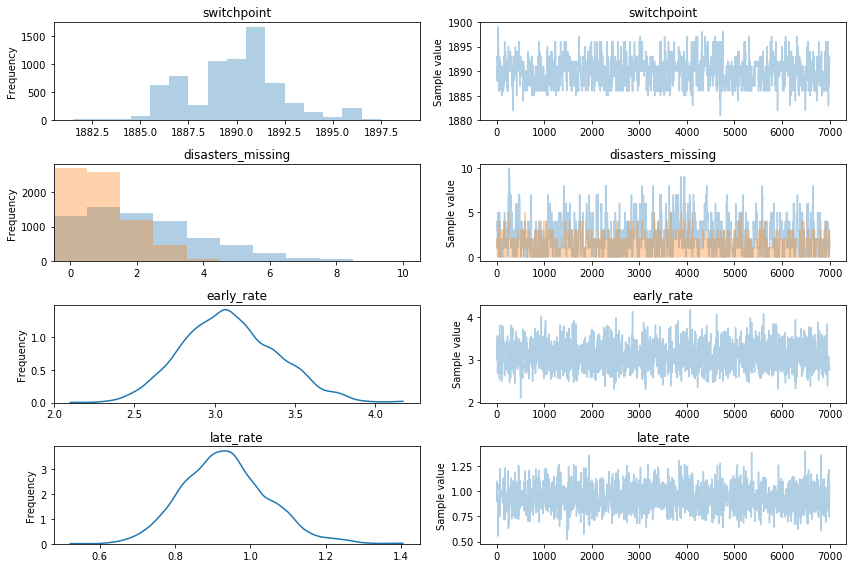

In [96]:
pm.traceplot(trace[3000:])

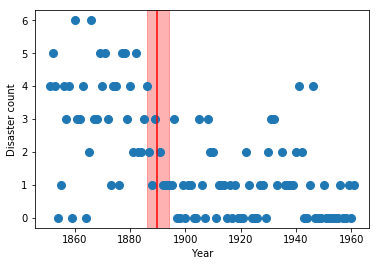

In [97]:
plt.plot(year, disaster_data, 'o', markersize=8);
data = trace[3000:].get_values('switchpoint')
plt.axvline(data.mean(), color='r')
plt.axvspan(np.percentile(data, 5), 
            np.percentile(data, 95), 
            alpha=.3, color='r')
plt.ylabel("Disaster count")
plt.xlabel("Year")


## Volatility

401


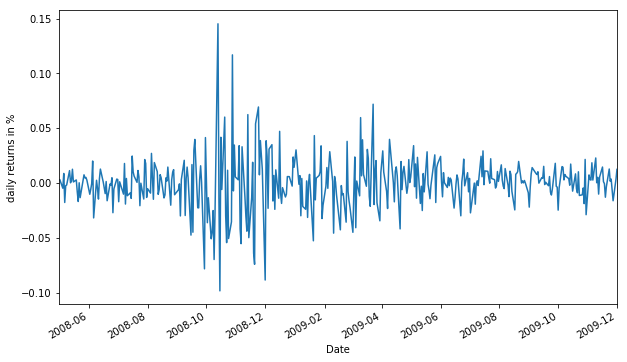

In [138]:
from pandas_datareader import data
import pandas as pd

returns = data.get_data_yahoo('SPY', start='2008-5-1', end='2009-12-1')['Adj Close'].pct_change()

print(len(returns))

returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [167]:
from pymc3.math import exp
from pymc3.distributions.timeseries import GaussianRandomWalk

D = BayesianNetwork()
D.add_node('nu', dist=pm.Exponential,
           lam=1./10., testval=5.,
           dist_type='Exponential')
D.add_node('sigma', dist=pm.Exponential, 
           lam=1./.02, testval=.1,
          dist_type='Exponential')
D.add_node('s', dist=GaussianRandomWalk,
           tau=lambda: D.d('sigma')**-2, 
           dist_type='GaussianRW', shape=len(returns))
D.add_edge('sigma', 's', var='tau')

D.add_node('volatility_process', dist=pm.Deterministic,
           var=lambda: exp(-2*D.d('s')), 
           dist_type='Deterministic')
D.add_edge('s', 'volatility_process', var='var')

D.add_node('r', dist=pm.StudentT, 
           nu = lambda:D.d('nu'),
           lam = lambda: 1./D.d('volatility_process'), 
           observed = returns, dist_type='StudentT')
D.add_edge('nu', 'r', var='nu')
D.add_edge('volatility_process', 'r', var='lam')

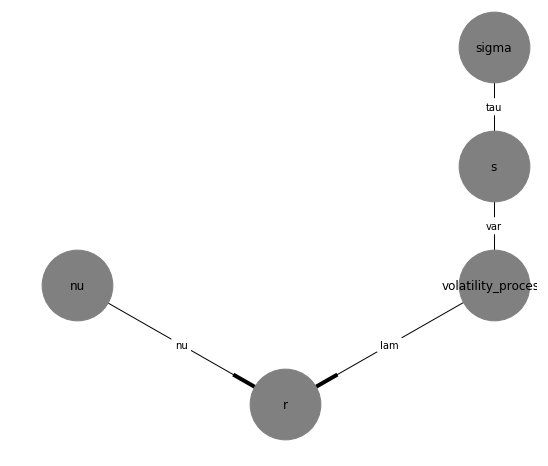

In [168]:
plt.figure(figsize=(7,6))
labels = {k:D.edge[k[0]][k[1]]['var'] for k in D.edges()}
pos=graphviz_layout(D,prog='dot')
nx.draw(D,pos,with_labels=True,arrows=True, node_size=5000, node_color='gray')
nx.draw_networkx_edge_labels(D, pos, rotate=False, 
                             edge_labels=labels);

In [169]:
with pm.Model() as model:
    instantiate_pm(D)

nu
root node; keys:  ['lam', 'testval']
sigma
root node; keys:  ['lam', 'testval']
s
child node; keys:  ['tau', 'shape']
volatility_process
child node; keys:  ['var']
r
child node; keys:  ['observed', 'lam', 'nu']


In [171]:
with model:
    trace=pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = 883.23: 100%|█████████| 200000/200000 [00:49<00:00, 4078.64it/s]
Finished [100%]: Average ELBO = 883.26
100%|██████████████████████████████████████| 2000/2000 [02:06<00:00, 15.80it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003EBFD898>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000003ED733C8>]], dtype=object)

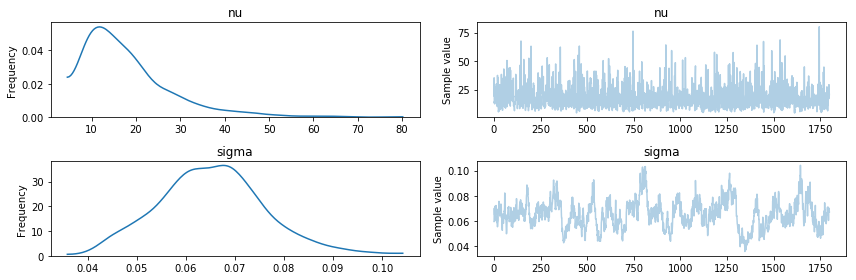

In [172]:
pm.traceplot(trace[200:], [D.d('nu'), D.d('sigma')])

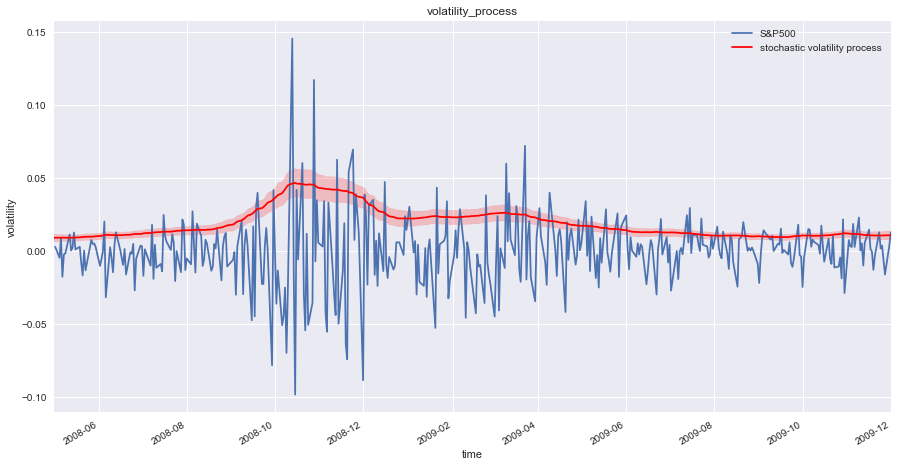

In [227]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
samps = pd.DataFrame(columns=['S.{}'.format(i) for i in range(1000)], 
                     data=1./np.exp(trace['s',::2]).T, index=returns.index)
# samps['date']=returns.index.values()
ax.plot(samps.index, samps.mean(axis=1), 'r');
ax.fill_between(samps.index, samps.quantile(.1,axis=1), 
                samps.quantile(.9,axis=1), color='r', alpha=0.2)
# sns.tsplot(samps, time='date')

ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process'])
# pd.DataFrame.quantile()

## Welding BN

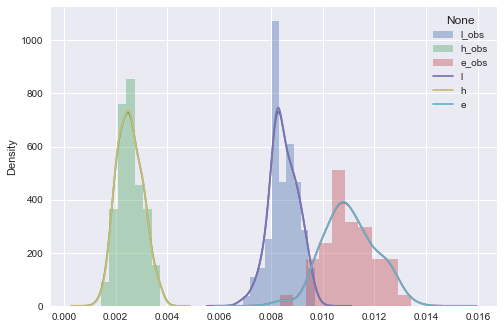

In [365]:
from scipy.stats import norm

# Synthetic Data-set (observations)
np.random.seed(19806) #random.org

num_obs = 100
l_obs = norm(8.5*1e-3, 0.5*1e-3).rvs(size=100)
h_obs = norm(2.6*1e-3, 0.5*1e-3).rvs(size=100)
e_obs = norm(11.*1e-3, 1.*1e-3).rvs(size=100)



for i in [l_obs, h_obs, e_obs]:
    sns.distplot(i) 
plt.legend([
    'l_obs',
    'h_obs',
    'e_obs'
])
synth = pd.DataFrame(data=np.array([l_obs, h_obs, e_obs]).T, 
                     columns=['l','h','e'])
# synth = np.loadtxt('./pmml_bayesnet/use_pymc3/Weld_UQ_data.txt',
#                    skiprows=0, usecols=(0,1,2))
# synth=pd.DataFrame(data=synth, columns=['l','h','e'])
synth.plot.kde(ax=plt.gca())

In [352]:
n_samp = 10000

# import theano.tensor as T
D = BayesianNetwork()

D.add_node('mu_l', dist = pm.Uniform, 
           lower=8.3e-3, upper=8.6e-3, 
           dist_type='Uniform')
D.add_node('sd_l', dist = pm.Uniform,
           lower=0.2e-3, upper=0.7e-3,
           dist_type='Uniform')
D.add_node('l', dist=pm.Normal, 
           mu=lambda : D.d('mu_l'),
           sd=lambda: D.d('sd_l'),
           dist_type='Normal', 
           observed=synth['l'])
D.add_edge('mu_l','l', var='mu')
D.add_edge('sd_l', 'l', var='sd')

D.add_node('mu_h', dist = pm.Uniform, 
           lower=2.5e-3, upper=2.8e-3, 
           dist_type='Uniform')
D.add_node('sd_h', dist = pm.Uniform,
           lower=0.3e-3, upper=0.6e-3,
           dist_type='Uniform')
D.add_node('h', dist=pm.Normal, 
           mu=lambda: D.d('mu_h'),
           sd=lambda: D.d('sd_h'),
           dist_type='Normal', 
           observed=synth['h'])
D.add_edge('mu_h','h', var='mu')
D.add_edge('sd_h', 'h', var='sd')

D.add_node('mu_e', dist = pm.Uniform, 
           lower=10e-3, upper=13e-3, 
           dist_type='Uniform')
D.add_node('sd_e', dist = pm.Uniform,
           lower=0.8e-3, upper=1.3e-3,
           dist_type='Uniform')
D.add_node('e', dist=pm.Normal, 
           mu=lambda: D.d('mu_e'),
           sd=lambda: D.d('sd_e'),
           dist_type='Normal', 
           observed=synth['e'])
D.add_edge('mu_e','e', var='mu')
D.add_edge('sd_e', 'e', var='sd')

D.add_node('L', dist = pm.Normal, 
           mu=500e-3, sd=10e-3, 
           dist_type='Normal')
D.add_node('g', dist = pm.Normal, 
           mu=2e-3, sd=0.1e-3, 
           dist_type='Normal')
D.add_node('t', dist = pm.Normal, 
           mu=15e-3, sd=0.5e-3, 
           dist_type='Normal')
def vol_p():
#     print type(l), type(e), type(h), type(g), type(t)
    return D.d('L')*((3./4.)*D.d('mu_l')*D.d('mu_h') +\
                            D.d('g')*D.d('t') +\
                     (D.d('mu_l')-D.d('g'))*(D.d('t')-D.d('mu_e'))/2.)


D.add_node('V', dist=pm.Deterministic, 
           var =  vol_p, 
           dist_type='Deterministic')
D.add_edges_from([(i,'V') for i in ['L', 'mu_l','mu_h','g','t','mu_e']], 
                 var='var')

D.add_node('Density', dist=pm.Normal,
           mu=8238., sd=10.,
          dist_type='Normal')
D.add_node('H', dist=pm.Normal,
           mu=270e3, sd=3e3,
           dist_type='Normal')
D.add_node('C_p', dist=pm.Normal,
           mu=500., sd=5.,
           dist_type='Normal')
D.add_node('T_i', dist=pm.Normal,
           mu=303., sd=.3,
           dist_type='Normal'),
D.add_node('T_f', dist=pm.Normal,
           mu=1628., sd=10.,
           dist_type='Normal')
def nrg():
    return D.d('Density')*(D.d('C_p')*(D.d('T_f')-D.d('T_i')) +\
                           D.d('H'))*D.d('V')
D.add_node('Energy', dist=pm.Deterministic, 
           var = nrg, 
           dist_type = 'Deterministic')

D.add_edges_from([(i,'Energy') for i in ['Density', 'C_p', 
                                         'T_f', 'T_i', 
                                         'H', 'V']], var='var')

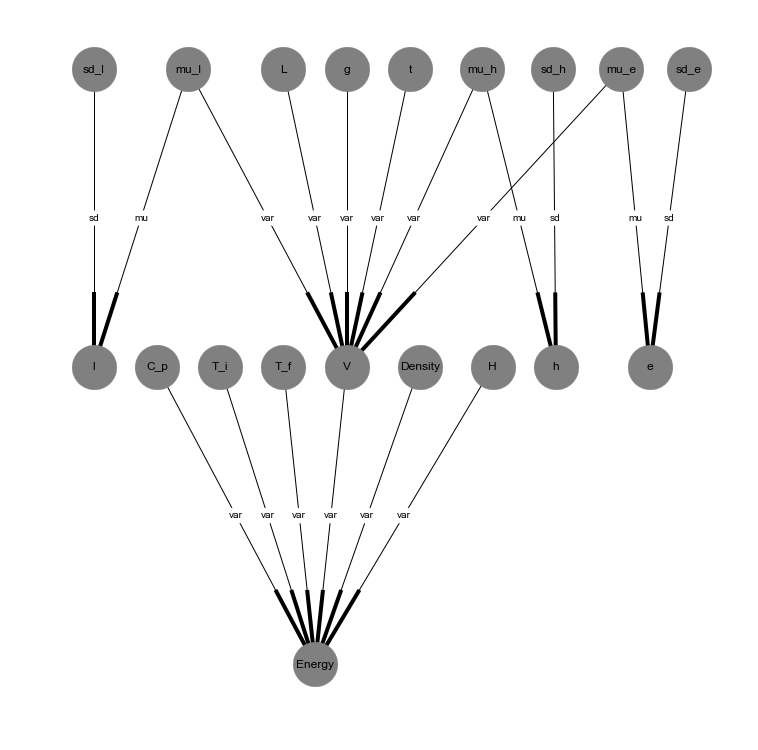

In [353]:
plt.figure(figsize=(10,10))
labels = {k:D.edge[k[0]][k[1]]['var'] for k in D.edges()}
pos=graphviz_layout(D,prog='dot')
nx.draw(D,pos,with_labels=True,arrows=True, node_size=2000, node_color='gray')
nx.draw_networkx_edge_labels(D, pos, rotate=False, 
                             edge_labels=labels);

In [354]:
with pm.Model() as model:
    instantiate_pm(D)

mu_l
root node; keys:  ['upper', 'lower']
sd_l
root node; keys:  ['upper', 'lower']
l
child node; keys:  ['observed', 'mu', 'sd']
mu_h
root node; keys:  ['upper', 'lower']
sd_h
root node; keys:  ['upper', 'lower']
h
child node; keys:  ['observed', 'mu', 'sd']
mu_e
root node; keys:  ['upper', 'lower']
sd_e
root node; keys:  ['upper', 'lower']
e
child node; keys:  ['observed', 'mu', 'sd']
L
root node; keys:  ['mu', 'sd']
g
root node; keys:  ['mu', 'sd']
t
root node; keys:  ['mu', 'sd']
V
child node; keys:  ['var']
Density
root node; keys:  ['mu', 'sd']
H
root node; keys:  ['mu', 'sd']
C_p
root node; keys:  ['mu', 'sd']
T_i
root node; keys:  ['mu', 'sd']
T_f
root node; keys:  ['mu', 'sd']
Energy
child node; keys:  ['var']


In [356]:

with model:
#     start = pm.find_MAP()
    step=pm.Metropolis()
    trace=pm.sample(n_samp, step=step)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -6.2306e+06:  20%|▉    | 39140/200000 [00:06<00:28, 5720.71it/s]Median ELBO converged.
Finished [100%]: Average ELBO = 15,945

Evidence of divergence detected, inspect ELBO.
INFO (theano.gof.compilelock): Refreshing lock C:\Users\tbs4\AppData\Local\Theano\compiledir_Windows-7-6.1.7601-SP1-Intel64_Family_6_Model_58_Stepping_9_GenuineIntel-2.7.13-64\lock_dir\lock
100%|███████████████████████████████████| 10000/10000 [00:28<00:00, 350.63it/s]


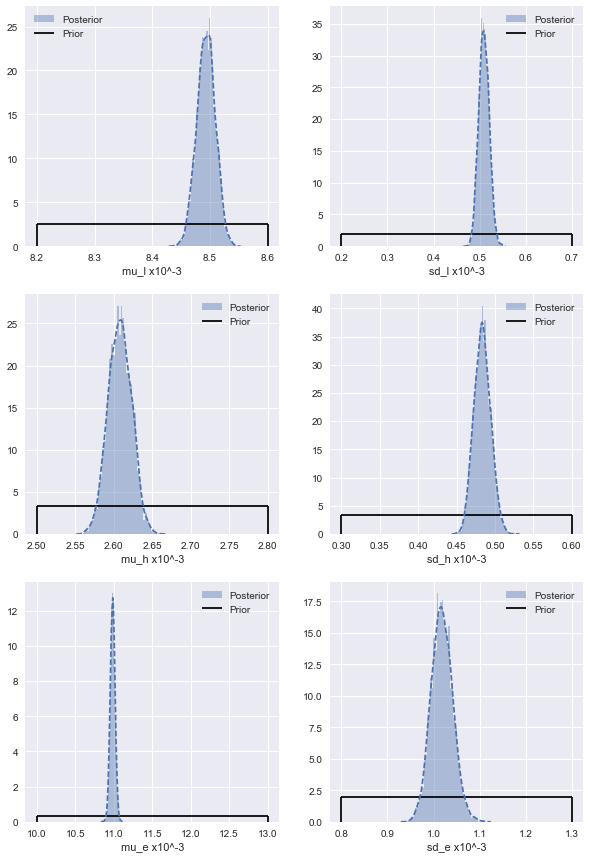

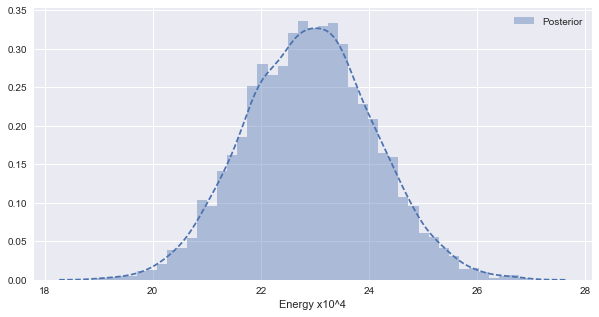

In [357]:
lims = [(8.2e-3, 8.6e-3),
        (0.2e-3, 0.7e-3),
        (2.5e-3, 2.8e-3),
        (0.3e-3, 0.6e-3),
        (10e-3, 13e-3),
        (0.8e-3, 1.3e-3)]
varnames=['mu_l', 'sd_l',
          'mu_h', 'sd_h',
          'mu_e', 'sd_e']

def compare_dist(ax, dat, lim, scale=1.):
    sns.distplot(scale*dat, ax=ax, kde=True, label='Posterior', kde_kws={'ls':'--'})
    a,b = scale*lim[0], scale*lim[1]
    y = 1./(b-a)
    ax.hlines(y=y, xmin=a, xmax=b, linestyles=u'solid', label='Prior')
    ax.vlines([a,b],ymin=0, ymax=y, linestyles=u'solid')
    ax.legend()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))

for n, ax in enumerate(axes.flat):
    compare_dist(ax, trace[n_samp/2:].get_values(D.d(varnames[n])), lims[n], scale=1e3)
    ax.set_xlabel("{} x10^{}".format(varnames[n], -3))


f2 = plt.figure(figsize=(10,5))
sns.distplot(trace[n_samp/2:].get_values('Energy')*1e-4, kde=True, label='Posterior', kde_kws={'ls':'--'})
# sns.distplot(trace_prior[n_samp/2:].get_values('Energy')*1e-4, label='Prior', kde_kws={'color':'k'})
plt.legend()
plt.xlabel('Energy x10^{}'.format(4))

In [325]:
import sympy as sy
from sympy.printing.dot import dotprint
from sympy.printing.mathml import print_mathml, mathml
variables = sy.symbols(D.nodes())
vexpr = sy.sympify('L*((3/4)*l*h + g*t + (l-g)*(t-e)/2)')
eexpr=sy.sympify('Density*(C_p*(T_f-T_i) + H)*V')
print variables
print sy.srepr(vexpr)
print sy.srepr(eexpr)
print_mathml(expr)


Mul(Symbol('L'), Add(Mul(Symbol('g'), Symbol('t')), Mul(Rational(3, 4), Symbol('h'), Symbol('l')), Mul(Rational(1, 2), Add(Mul(Integer(-1), Symbol('e')), Symbol('t')), Add(Mul(Integer(-1), Symbol('g')), Symbol('l')))))
Mul(Symbol('Density'), Symbol('V'), Add(Mul(Symbol('C_p'), Add(Symbol('T_f'), Mul(Integer(-1), Symbol('T_i')))), Symbol('H')))
<apply>
	<times/>
	<ci>Density</ci>
	<ci>V</ci>
	<apply>
		<plus/>
		<apply>
			<times/>
			<ci>
				<mml:msub>
					<mml:mi>C</mml:mi>
					<mml:mi>p</mml:mi>
				</mml:msub>
			</ci>
			<apply>
				<minus/>
				<ci>
					<mml:msub>
						<mml:mi>T</mml:mi>
						<mml:mi>f</mml:mi>
					</mml:msub>
				</ci>
				<ci>
					<mml:msub>
						<mml:mi>T</mml:mi>
						<mml:mi>i</mml:mi>
					</mml:msub>
				</ci>
			</apply>
		</apply>
		<ci>H</ci>
	</apply>
</apply>

[mu_l, sd_l, l, mu_h, sd_h, h, mu_e, sd_e, e, L, g, t, V, Density, H, C_p, T_i, T_f, Energy]


## Baseball Trajectory

C:\Users\tbs4\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
100%|██████████████████████████████████████| 2000/2000 [02:20<00:00, 14.25it/s]


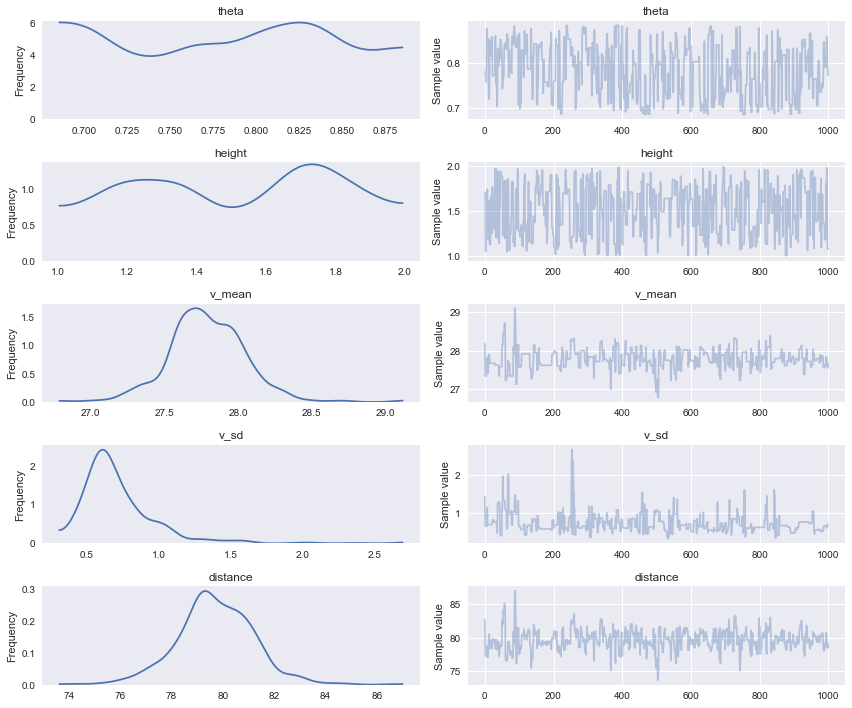

In [326]:
from pymc3.math import sin, cos, sqrt
from theano.tensor import mean
#synthetic test throws
np.random.seed(19806) #random.org
v_obsv = np.random.normal(loc=28., scale=1., size=10.)  # m/s

#gravity
g = 9.81  # m/s**2

with pm.Model() as projectile_model:
    th = pm.Uniform('theta', np.pi/4.-.1, np.pi/4.+.1) # close to 45deg
    y_0 = pm.Uniform('height', 1, 2)  # about man-height
    
    v_mu = pm.Uniform('v_mean', 1, 30) # from slow to best known 
    v_sd = pm.HalfCauchy('v_sd', 5.)
    v = pm.Normal('velocity', v_mu, v_sd, observed = v_obsv)
    
    # known trajectory equation
    d = pm.Deterministic('distance', v_mu*cos(th)*\
                         (v_mu*sin(th) + sqrt((v_mu*sin(th))**2+2*g*y_0))/g)
with projectile_model:
    step=pm.Metropolis()
    proj_trace=pm.sample(2000, step=step)
    
pm.traceplot(proj_trace[1000:]);
    

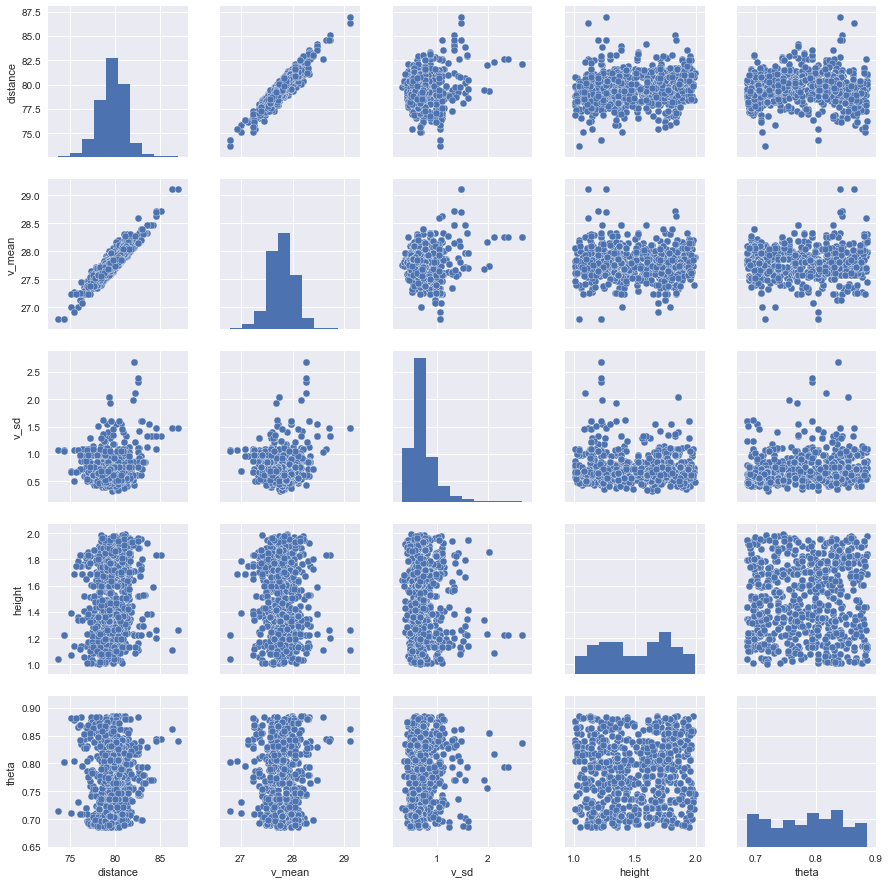

In [327]:
# sns.jointplot(proj_trace[1000:].get_values('distance'), 
#             proj_trace[1000:].get_values('v_mean'),
#             kind='hex')

sns.pairplot(pd.DataFrame(data=pm.trace_to_dataframe(proj_trace[1000:])))

In [361]:
[n for n in D.nodes() if not 'observed' in D.node[n]]

['mu_l',
 'sd_l',
 'mu_h',
 'sd_h',
 'mu_e',
 'sd_e',
 'L',
 'g',
 't',
 'V',
 'Density',
 'H',
 'C_p',
 'T_i',
 'T_f',
 'Energy']

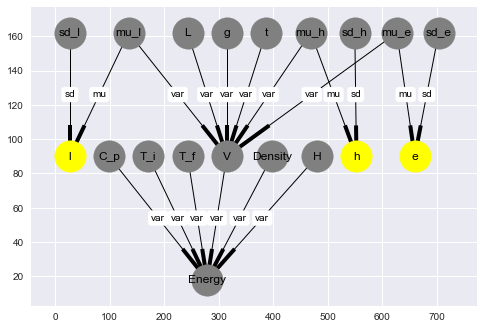